Trashure

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import shutil
from shutil import copyfile
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from scipy import ceil
import scipy

Baca Data

In [3]:
source_path = 'Data'


list=[]

for i in os.listdir(source_path):
    source_path_item = os.path.join(source_path, i)
    n = 0
    for j in os.listdir(source_path_item):
        if j[-3:] == "jpg" or j[-3:] == "gif":
            im = Image.open(os.path.join(source_path_item, j)).convert("RGB")
            im.save(os.path.join(source_path_item, j[:-3]+'jpeg'))
               
            os.remove(os.path.join(source_path_item, j))
            n += 1

    print("Convert Successful")
    print("Converted image =",n)
    print(f"There are {len(os.listdir(source_path_item))} images of", i + ".\n")
    list.append(i)

Convert Successful
Converted image = 0
There are 10 images of botol.

Convert Successful
Converted image = 0
There are 6 images of kaleng.

Convert Successful
Converted image = 0
There are 6 images of Organik.



In [4]:
root_dir = './temp'

if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

for i in list:
    os.makedirs(os.path.join(root_dir,"train",i))
    os.makedirs(os.path.join(root_dir,"validation",i))

In [5]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  random_sample=random.sample(os.listdir(SOURCE_DIR),len(os.listdir(SOURCE_DIR)))

  size=int(len(random_sample)*SPLIT_SIZE)

  target=TRAINING_DIR
  i=0

  for item in random_sample:
    
    item_source = os.path.join(SOURCE_DIR, item)

    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else: 
      copyfile(item_source, os.path.join(target, item))
      i += 1

    if i == size:
      target = VALIDATION_DIR

In [6]:
train_dir = os.path.join(root_dir,"train")
val_dir = os.path.join(root_dir,"validation")

for i in os.listdir(train_dir):
  path = os.path.join(train_dir,i)
  if len(os.listdir(path))>0:
    for file in os.scandir(path):
      os.remove(file.path)

for i in os.listdir(val_dir):
  path = os.path.join(val_dir,i)
  if len(os.listdir(path))>0:
    for file in os.scandir(path):
      os.remove(file.path)

split_size = .8

for i in list:
  split_data(os.path.join(source_path,i), os.path.join(train_dir, i), os.path.join(val_dir, i), split_size)
  print("Split", i, "Successful")
  print(f"There are {len(os.listdir(os.path.join(train_dir,i)))} images of", i + " for training.")
  print(f"There are {len(os.listdir(os.path.join(val_dir,i)))} images of", i + " for validation.\n")

Split botol Successful
There are 8 images of botol for training.
There are 2 images of botol for validation.

Split kaleng Successful
There are 4 images of kaleng for training.
There are 2 images of kaleng for validation.

Split Organik Successful
There are 4 images of Organik for training.
There are 2 images of Organik for validation.



In [7]:
NUM_CLASSES = len(os.listdir(source_path))

BATCH_SIZE = 60

base_model = tf.keras.applications.VGG16(input_shape=(225,225,3),
                                         include_top=False,
                                         weights='imagenet')

In [7]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 225, 225, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 225, 225, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 225, 225, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
last_desired_layer = base_model.get_layer("block5_pool")

last_output = last_desired_layer.output

In [9]:
for layer in base_model.layers:
 layer.trainable = False
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x) 
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
x = tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')(x) 

model = tf.keras.models.Model(inputs = base_model.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 225, 225, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 225, 225, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 225, 225, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(225,225), 
                                                    shuffle=False, 
                                                    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(directory=val_dir, 
                                                              target_size=(225,225),
                                                              shuffle=False, 
                                                              class_mode='categorical')

training_steps_per_epoch = np.ceil(train_generator.samples / BATCH_SIZE)
validation_steps_per_epoch = np.ceil(validation_generator.samples / BATCH_SIZE)

history = model.fit(train_generator, 
                    steps_per_epoch = training_steps_per_epoch, 
                    validation_data=validation_generator, 
                    validation_steps=validation_steps_per_epoch,
                    epochs=25, 
                    verbose=1)

print('Training Completed!')

Found 16 images belonging to 3 classes.
Found 6 images belonging to 3 classes.


Epoch 1/25


1/1 [==============================] - 3s 3s/step - loss: 1.0815 - accuracy: 0.3750 - val_loss: 1.1162 - val_accuracy: 0.3333
Epoch 2/25
1/1 [==============================] - 2s 2s/step - loss: 0.7443 - accuracy: 0.7500 - val_loss: 2.1171 - val_accuracy: 0.6667
Epoch 3/25
1/1 [==============================] - 2s 2s/step - loss: 1.3071 - accuracy: 0.7500 - val_loss: 1.8555 - val_accuracy: 0.3333
Epoch 4/25
1/1 [==============================] - 2s 2s/step - loss: 1.1993 - accuracy: 0.5000 - val_loss: 0.5974 - val_accuracy: 0.6667
Epoch 5/25
1/1 [==============================] - 2s 2s/step - loss: 0.1363 - accuracy: 1.0000 - val_loss: 1.1672 - val_accuracy: 0.3333
Epoch 6/25
1/1 [==============================] - 2s 2s/step - loss: 0.3932 - accuracy: 0.7500 - val_loss: 0.4751 - val_accuracy: 0.8333
Epoch 7/25
1/1 [==============================] - 2s 2s/step - loss: 0.0952 - accuracy: 0.9375 - val_loss: 0.2285 - val_accuracy: 1.0000
Epoch 8/25
1/1 [=======================

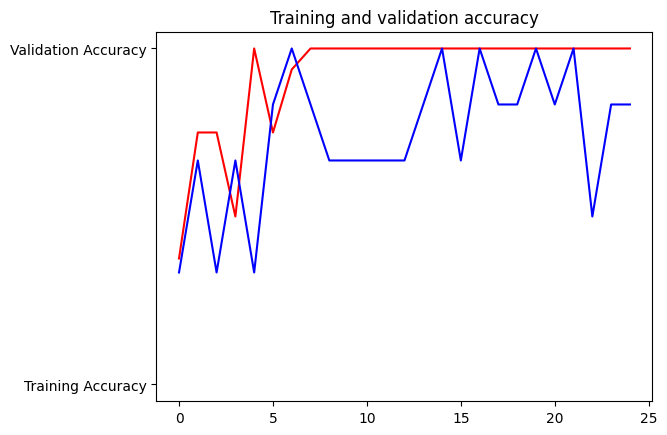

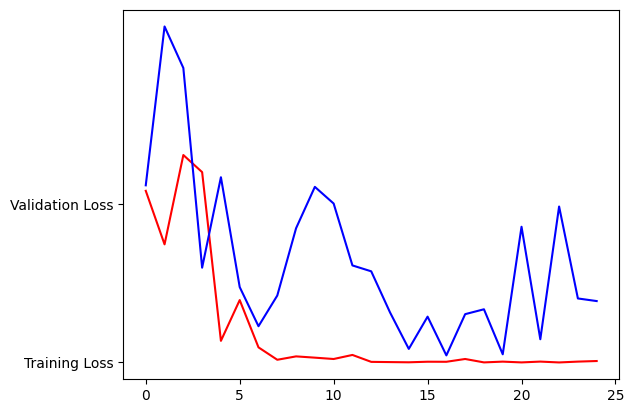

In [12]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

C:\Users\Devan\AppData\Local\Temp\ipykernel_17540\2404799955.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator)


[[2 0 0]
 [1 1 0]
 [0 0 2]]
              precision    recall  f1-score   support

       botol       0.67      1.00      0.80         2
      kaleng       1.00      0.50      0.67         2
     Organik       1.00      1.00      1.00         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6



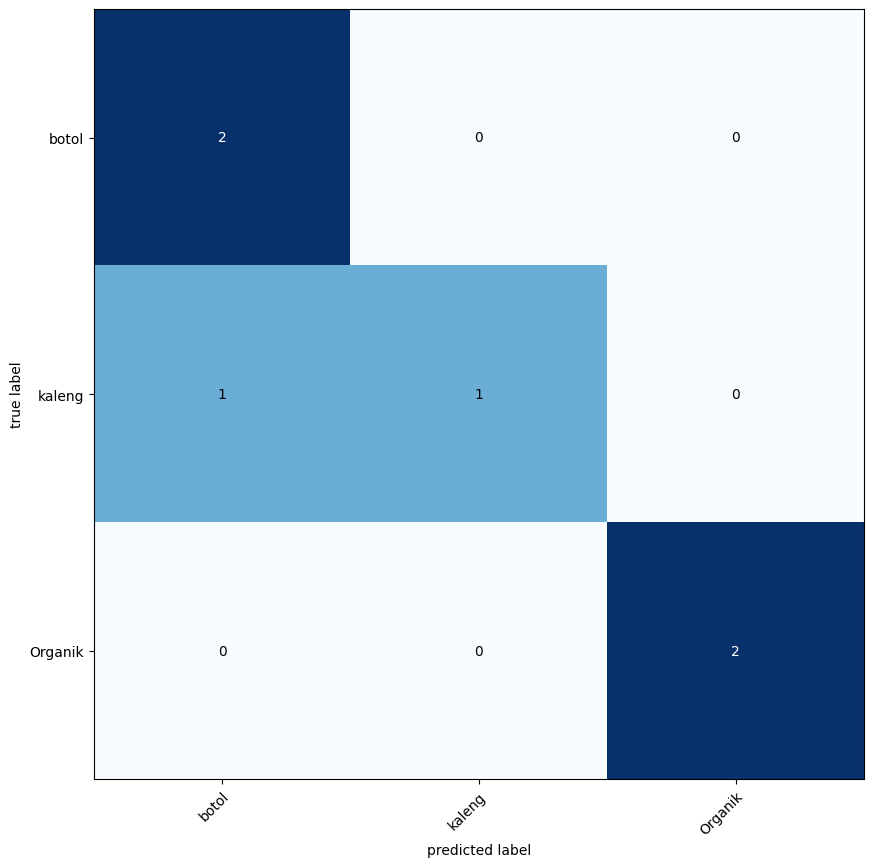

In [14]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
mat = confusion_matrix(validation_generator.classes, y_pred)
print(mat)
plot_confusion_matrix(conf_mat=mat, figsize=(10,10), class_names= list)
print(classification_report(validation_generator.classes, y_pred, target_names=list))

In [15]:
model.save('saved_model/model1')

INFO:tensorflow:Assets written to: saved_model/model1\assets


INFO:tensorflow:Assets written to: saved_model/model1\assets
